In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
       """find a notebook, given its fully qualified name and an optional path

       This turns "foo.bar" into "foo/bar.ipynb"
       and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
       does not exist.
       """
       name = fullname.rsplit('.', 1)[-1]
       if not path:
           path = ['']
       for d in path:
           nb_path = os.path.join(d, name + ".ipynb")
           if os.path.isfile(nb_path):
               return nb_path
           # let import Notebook_Name find "Notebook Name.ipynb"
           nb_path = nb_path.replace("_", " ")
           if os.path.isfile(nb_path):
               return nb_path


class NotebookLoader(object):
       """Module Loader for Jupyter Notebooks"""
       def __init__(self, path=None):
           self.shell = InteractiveShell.instance()
           self.path = path

       def load_module(self, fullname):
           """import a notebook as a module"""
           path = find_notebook(fullname, self.path)

           print ("importing Jupyter notebook from %s" % path)

           # load the notebook object
           with io.open(path, 'r', encoding='utf-8') as f:
               nb = current.read(f, 'json')


           # create the module and add it to sys.modules
           # if name in sys.modules:
           #    return sys.modules[name]
           mod = types.ModuleType(fullname)
           mod.__file__ = path
           mod.__loader__ = self
           mod.__dict__['get_ipython'] = get_ipython
           sys.modules[fullname] = mod

           # extra work to ensure that magics that would affect the user_ns
           # actually affect the notebook module's ns
           save_user_ns = self.shell.user_ns
           self.shell.user_ns = mod.__dict__

           try:
               for cell in nb.worksheets[0].cells:
                   if cell.cell_type == 'code' and cell.language == 'python':
                       # transform the input to executable Python
                       code = self.shell.input_transformer_manager.transform_cell(cell.input)
                       # run the code in themodule
                       exec(code, mod.__dict__)
           finally:
               self.shell.user_ns = save_user_ns
           return mod


class NotebookFinder(object):
       """Module finder that locates Jupyter Notebooks"""
       def __init__(self):
           self.loaders = {}

       def find_module(self, fullname, path=None):
           nb_path = find_notebook(fullname, path)
           if not nb_path:
               return

           key = path
           if path:
               # lists aren't hashable
               key = os.path.sep.join(path)

           if key not in self.loaders:
               self.loaders[key] = NotebookLoader(path)
           return self.loaders[key]

sys.meta_path.append(NotebookFinder())

from KStationPositioning import heatmap

/home/michele/anaconda3/envs/ox/lib/python3.9/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


importing Jupyter notebook from KStationPositioning.ipynb


In [11]:
#scrittura df per test
import pandas as pd
from shapely.geometry import Point, Polygon,box
import yaml
import geopandas as gpd
import cartopy.geodesic as GD

with open('conf.yaml') as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
pathBox = conf["pathBox"]
path = conf["path"]
pathDFLow = conf["pathDFLow"]
pathDFNormal = conf["pathDFNormal"]
pathDFHigh = conf["pathDFHigh"]
pathGeneral = conf['pathGeneral']
pathAreeProibite = conf["pathAreeProibite"]



#prelevamento dei dati 
GeneralDf = pd.read_csv(path, delimiter=',')
#rinomino le colonne
GeneralDf.rename(columns={'Unnamed: 0': 'index', 'Unnamed: 0.1' : 'index2'}, inplace=True)
#elimino le colonne che non servono
GeneralDf.drop(GeneralDf.columns[[0,1,2,3,6]], axis='columns', inplace=True)
print(GeneralDf.head())

#trasformo il dataframe in un gedoDataFrame
gdf = gpd.GeoDataFrame(GeneralDf,crs="EPSG:4326", geometry=gpd.points_from_xy(GeneralDf.lon, GeneralDf.lat))
gdf = gdf.drop(['lon', 'lat'], axis=1)
print(gdf.head())

#prelevo areeProibite
#Prelevo le aree proibite
areeProibite = gpd.GeoDataFrame(gpd.read_file(pathAreeProibite),crs = "EPSG:4326")
areeProibite=areeProibite['geometry']

#box generaldf
box_gdf = box(GeneralDf.lon.min(),GeneralDf.lat.min(),GeneralDf.lon.max(),GeneralDf.lat.max())



         lat         lon  probability
0  39.901209  116.478643     1.000000
1  39.846962  116.282636     0.817292
2  39.902166  116.421012     1.000000
3  39.740095  116.151421     1.000000
4  39.651827  116.790273     0.000000
   probability                    geometry
0     1.000000  POINT (116.47864 39.90121)
1     0.817292  POINT (116.28264 39.84696)
2     1.000000  POINT (116.42101 39.90217)
3     1.000000  POINT (116.15142 39.74010)
4     0.000000  POINT (116.79027 39.65183)


# Stampa della heatmap di tutti i punti all'interno del Dataframe


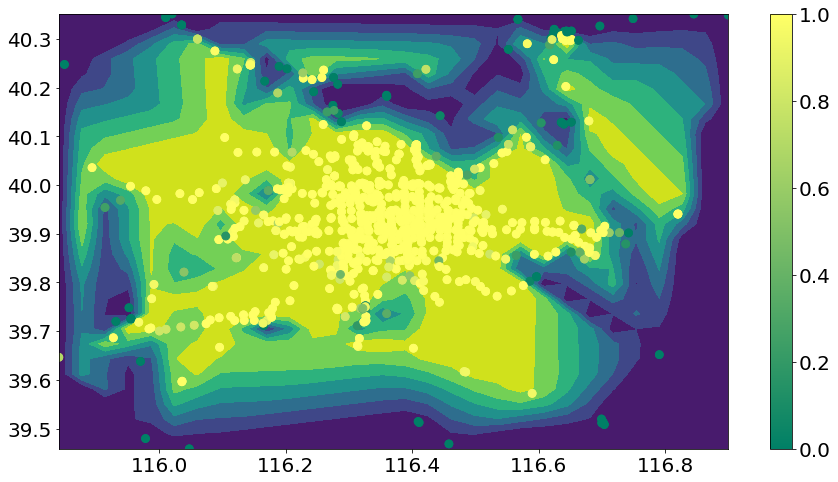

In [13]:
heatmap(gdf,gpd.GeoSeries(),box_gdf,pathGeneral)